In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'],mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

### View the displayed value

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
index = 0
some_digit = X.iloc[index]
some_digit_image = some_digit.to_numpy().reshape(28,28)

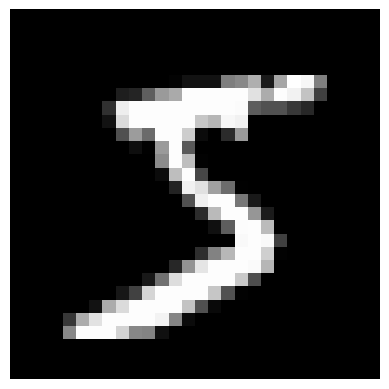

In [9]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary_r, interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
y[0]

'5'

### SInce the data is in string we convert it to integers

In [11]:
import numpy as np

y = y.astype(np.uint8)

In [12]:
X_train,X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Lets just train to identify 5 from the data using SGD

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [16]:
sgd_clf.predict([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Use CV to check accuracy

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype =bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
# pretend we reached perfection
y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision, Recall and F1 Scores

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")

In [31]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

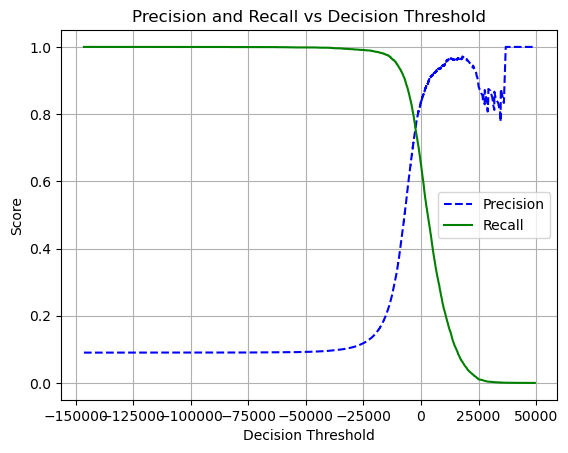

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Decision Threshold")
    plt.legend(loc="best")
    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]
threshold_90_precision

3370.0194991439594

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC curve

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

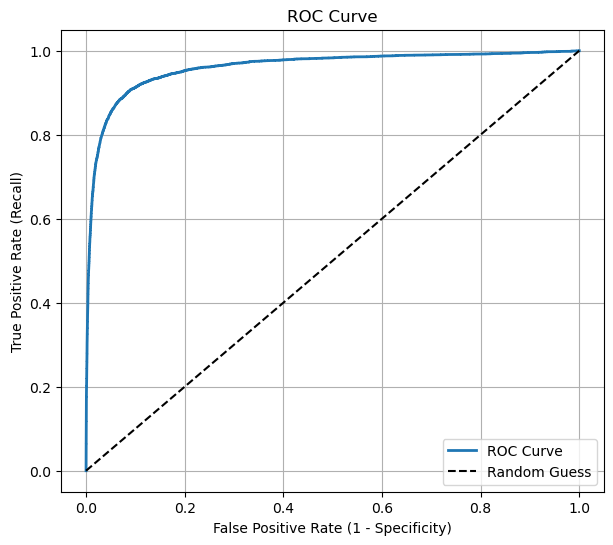

In [39]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label if label else "ROC Curve")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Example: plotting ROC curve
plot_roc_curve(fpr, tpr)


In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Since the ROC curve is so similar to the precision/recall (or PR curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top right corner)

### Now compare SGDClassifier and RandomForestClassifier ROC and AUC scores

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:,-1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

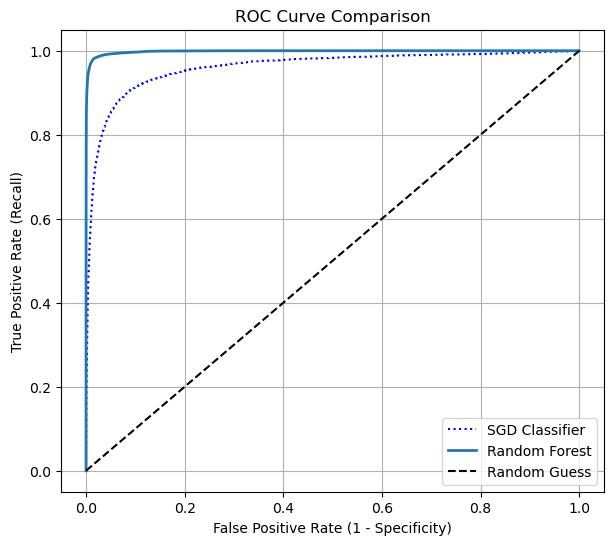

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# --- Main comparison ---
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, "b:", label="SGD Classifier")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

# Add random line, labels, legend, etc.
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
np.argmax(some_digit_scores)

3

In [48]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
sgd_clf.classes_[3]

3

### OvO classifier

In [53]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [55]:
len(ovo_clf.estimators_)

45

#### Now using RandomForestClassifier

In [56]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [57]:
forest_clf.predict_proba([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

#### You can see that the classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5. It also thinks that the image could instead be a 2, a 3 or a 9, respectively with 1%, 8% and 1% probability.

In [58]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

#### Confusion Matrix

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,y_train, cv= 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

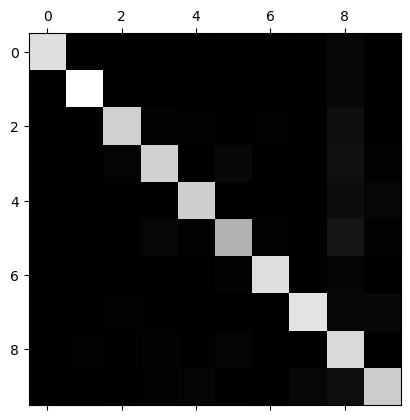

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

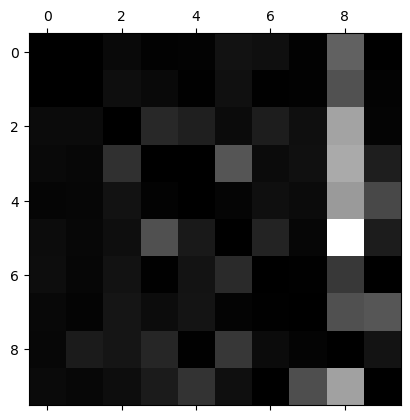

In [64]:
np.fill_diagonal(norm_conf_mx, 0 )
plt.matshow(norm_conf_mxconf_mx, cmap = plt.cm.gray)
plt.show()

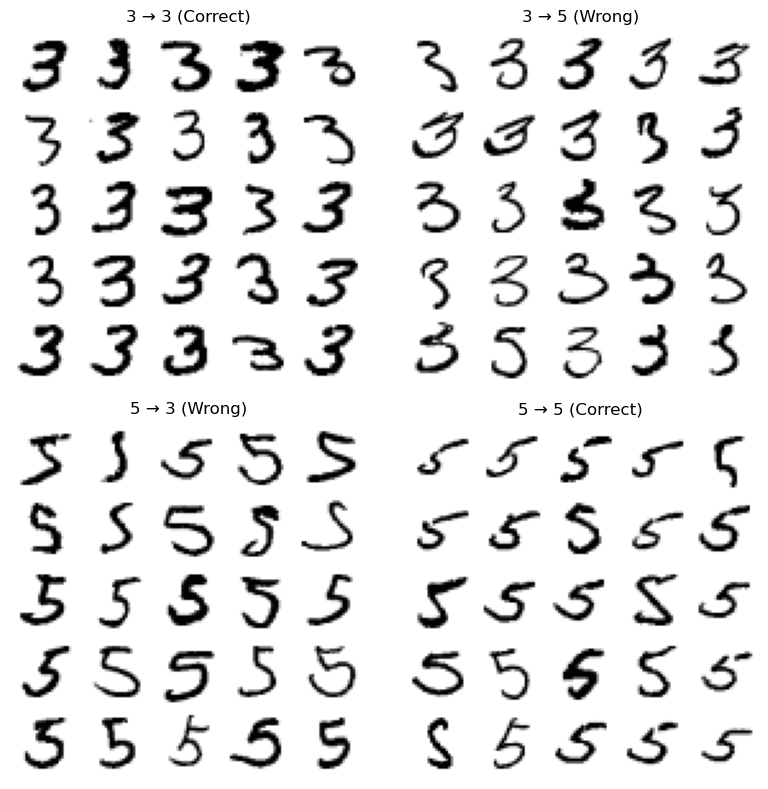

In [67]:
cl_a, cl_b = 3, 5

# Separate correct and incorrect predictions
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # 3s correctly predicted as 3s
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # 3s predicted as 5s
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # 5s predicted as 3s
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # 5s correctly predicted as 5s

def plot_digits(instances, images_per_row=10, **options):
    """Display a grid of digit images (for MNIST or sklearn.datasets.load_digits)."""
    size = int(np.sqrt(instances.shape[1]))  # auto-detect image size (28x28 or 8x8)
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)

    # pad with zeros if needed
    padded = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # reshape into grid
    image_grid = padded.reshape((n_rows, images_per_row, size, size))
    big_image = np.block([[image_grid[i, j] for j in range(images_per_row)]
                          for i in range(n_rows)])
    plt.imshow(big_image, cmap=plt.cm.binary, **options)
    plt.axis("off")

# Plot the 4 categories
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5); plt.title("3 → 3 (Correct)")
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5); plt.title("3 → 5 (Wrong)")
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5); plt.title("5 → 3 (Wrong)")
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5); plt.title("5 → 5 (Correct)")
plt.tight_layout()
plt.show()


### Multilabel Classification

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 ==1) 
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [70]:
knn_clf.predict([some_digit])

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [71]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

### Multioutput Classification

In [74]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

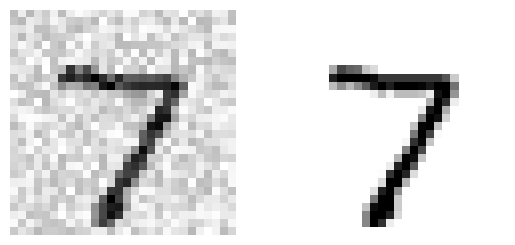

In [85]:
def plot_digit(data):
    """Displays a 28x28 image from a flattened array (like in MNIST)."""
    image = data.reshape(28, 28)  # reshape 784 → 28×28
    plt.imshow(image, cmap=plt.cm.binary)
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


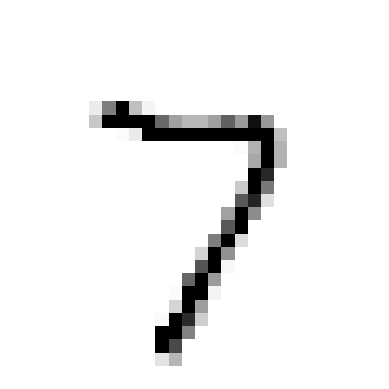

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
